## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
!nvidia-smi

Mon Jul 22 14:04:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
  input_layer = keras.layers.Input(input_shape)
  
  for i, n_units in enumerate(num_neurons):
    if i == 0:
      x = keras.layers.Dense(units = n_units,
                                      activation = 'relu',
                                      name = 'hidden_layer' + str(i + 1))(input_layer)
      x = BatchNormalization()(x)
    else:
      x = keras.layers.Dense(units = n_units,
                                      activation = 'relu',
                                      name = 'hidden_layer' + str(i + 1))(x)
      x = BatchNormalization()(x)
  out = keras.layers.Dense(units = output_units, activation = 'softmax', name = 'output')(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [out])
  return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
Save_best = [True,False]

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint
results = {}
for i, save_bst in enumerate(Save_best):
    keras.backend.clear_session()
    print('Experiment with the model checkpoint is %s' %save_bst)
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    if i == 0:
      tmp = True
      model_ckpt = ModelCheckpoint(filepath = './hw_'+ str(tmp)+'.h5' ,monitor = 'val_loss',save_best_only = save_bst )
    else:
      tmp = False
      model_ckpt = ModelCheckpoint(filepath = './hw_'+ str(tmp)+'.h5' ,monitor = 'val_loss',save_best_only = save_bst )
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizer)
    model.fit(x_train, y_train, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(x_test, y_test), 
            callbacks = [model_ckpt],
            shuffle=True)

   # Load back
    model2 = keras.models.load_model('./hw_'+ str(tmp)+'.h5')
    loss_loadback, acc_loadback = model2.evaluate(x_test, y_test)
   # Collect results 
    exp_name_tag = ('exp-%s' % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"],
                             'loss_loadback' : loss_loadback,
                             'acc_loadback' : acc_loadback}

Experiment with the model checkpoint is True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (N

0 ==> save_best_only is True
1 ==> save_best_only is False


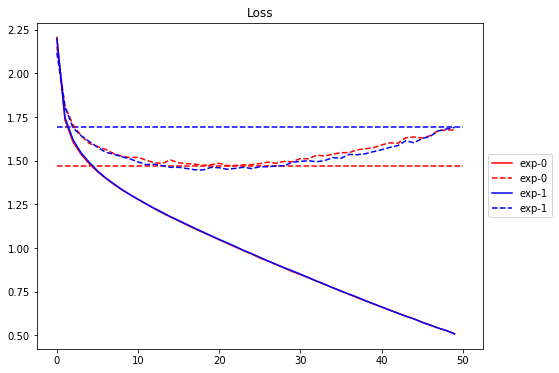

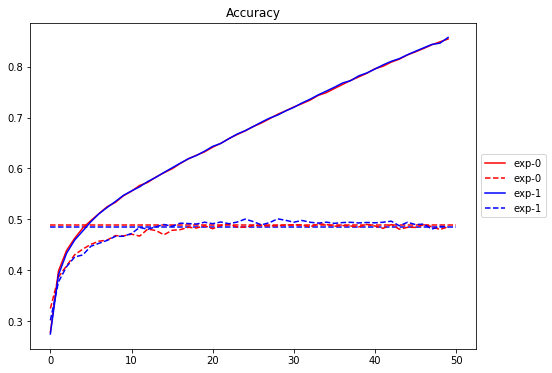

In [16]:
print('0 ==> save_best_only is True')
print('1 ==> save_best_only is False')
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['r', 'b']
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y = results[cond]['loss_loadback'], xmin = 0, xmax = len(results[cond]['train-loss']), colors = color_bar[i] , linestyles = '--' )
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y = results[cond]['acc_loadback'], xmin = 0, xmax = len(results[cond]['train-loss']), colors = color_bar[i] , linestyles = '--' )
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()